In [1]:
# importing the necessary libraries
import pandas as pd
import re
import string
import nltk        
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Reading the file
file_path = r'C:\Users\Julie Musangi\Desktop\DS Course Material\Phase-5\consumer_complaints_analysis\data_comp.zip'

with zipfile.ZipFile(file_path) as z:
    data = pd.read_csv(z.open('consumer_complaints.csv'), index_col=0)

## Data Exploration

In [3]:
# Checking the first 5 rows
data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


- The dataset has 2 columns, product and narrative (customer complaint)

In [4]:
#Checking the information about the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162421 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    162421 non-null  object
 1   narrative  162411 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


- The dataFrame contains 162421 rows, and 2 columns both of the object datatype

In [5]:
# Checking for null values
data.isna().sum()

product       0
narrative    10
dtype: int64

- DataFrame contains 10 null values in the narrative column. These will be delt with during data cleaning

In [6]:
#Dropping the null values since they make a small proportion
data.dropna(inplace=True)
data.isna().sum()

product      0
narrative    0
dtype: int64

In [7]:
#Checking for duplicates
data.duplicated().sum()

37735

- The DataFrame has 37735 duplicates. I will drop the duplicates in the following section

In [8]:
data.drop_duplicates(subset=['product', 'narrative'], inplace= True) #Dropping the duplicates
data.shape # Checking the shape of the df after dropping duplicates

(124676, 2)

In [9]:
#Checking for unique values in the product column
data['product'].unique()

array(['credit_card', 'retail_banking', 'credit_reporting',
       'mortgages_and_loans', 'debt_collection'], dtype=object)

- The DataFrame contains customer complaints directed to 5 product offerings; `credit cards` , `retail banking` , `credit reporting` , `morgages and loans` , and `debit collection`. 

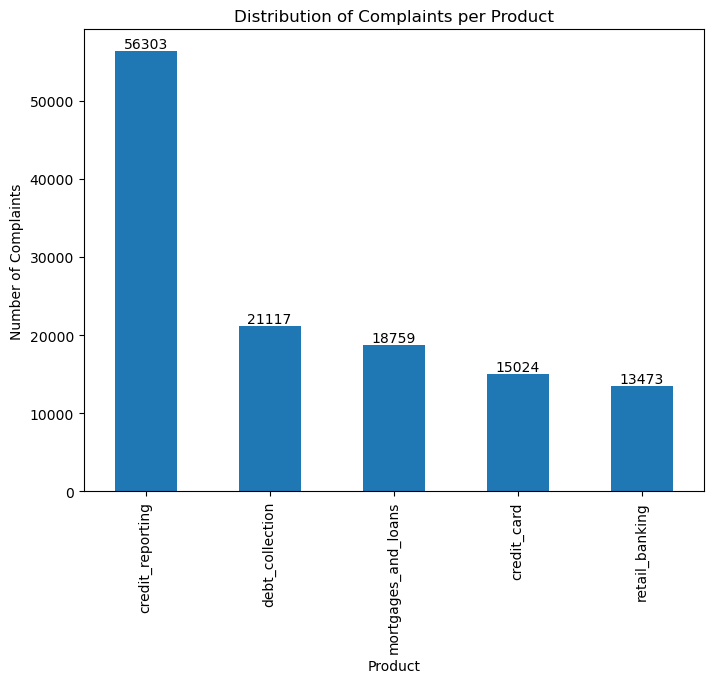

In [10]:
# plotting the distribution of complaints per product
complaints = data['product'].value_counts()

plt.figure(figsize=(8, 6))
ax = complaints.plot(kind='bar')
plt.title('Distribution of Complaints per Product')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=90)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

- The bar graph shows that majority of the customer complaints are in regard to credit reporting. The number is significantly larger than the rest of the product offerings, which range from 13,536 to 23,150.

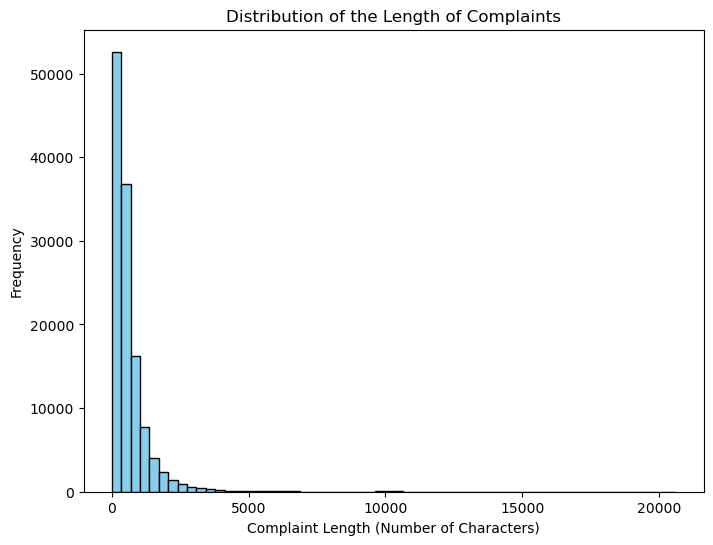

In [11]:
# Checking the distribution of the length of complaints
complaint_length = data['narrative'].str.len()

# Plot the distribution of tweet lengths
plt.figure(figsize=(8, 6))
plt.hist(complaint_length, bins = 60, color='skyblue', edgecolor='black')
plt.title('Distribution of the Length of Complaints')
plt.xlabel('Complaint Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

- Most customer complaints appear to be short in length, with only a small fraction of complaints being detailed or lengthy. This may suggest that customers tend to keep their complaints concise, or it could indicate specific complaint types that are resolved with fewer words.

## Text Preprocessing

In [12]:
# Importing relevant libraries for text preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Instantiating stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Julie
[nltk_data]     Musangi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Julie
[nltk_data]     Musangi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Julie
[nltk_data]     Musangi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Defining the Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # To remove punctuation
    words = word_tokenize(text)  # Tokenize
    words = [w for w in words if not w in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words]  # Lemmatize
    return ' '.join(words)

# Applying Text Preprocessing
data['cleaned_narrative'] = data['narrative'].apply(preprocess_text)

# Displaying a sample of the cleaned narratives
data[['narrative', 'cleaned_narrative']].head()

,narrative,cleaned_narrative
0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...
1,forwarded message date tue subject please inve...,forwarded message date tue subject please inve...
2,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...
3,payment history missing credit report speciali...,payment history missing credit report speciali...
4,payment history missing credit report made mis...,payment history missing credit report made mis...


In [14]:
%pip install wordcloud


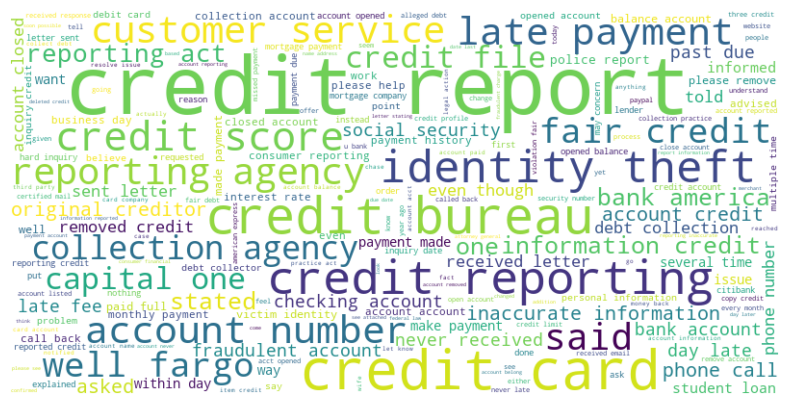

In [15]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(data['cleaned_narrative']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- This word cloud reveals that consumer complaints in the dataset predominantly revolve around credit-related issues, such as credit reporting, credit scores, and identity theft, indicating frequent problems in these areas. Terms like "credit bureau," "credit report," and "identity theft" suggest ongoing concerns with credit accuracy, score management, and identity protection. Additionally, financial institutions like Wells Fargo, Capital One, and Bank of America feature prominently, implying that these companies receive a substantial volume of complaints, possibly due to recurring issues or a large customer base. Common grievances include poor customer service, debt collection practices, billing issues, and fraud, highlighted by terms like "customer service," "late payment," and "collection agency." These insights suggest that credit and identity issues, along with financial service complaints, are significant pain points for consumers in this dataset.

## Label Encoding

In [16]:
# Encode Target Variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['product_encoded'] = label_encoder.fit_transform(data['product'])
data.head() 


,product,narrative,cleaned_narrative,product_encoded
0,credit_card,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...,0
1,credit_card,forwarded message date tue subject please inve...,forwarded message date tue subject please inve...,0
2,retail_banking,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...,4
3,credit_reporting,payment history missing credit report speciali...,payment history missing credit report speciali...,1
4,credit_reporting,payment history missing credit report made mis...,payment history missing credit report made mis...,1


## Splitting the Data & Feature Engineering

In [17]:
# Define X and y
X = data['cleaned_narrative']
y = data['product_encoded']

# Train-Test Split
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train_text) 
X_test = tfidf.transform(X_test_text)  

# Confirming the shape of the splits
print("Train set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Test set shape (X_test, y_test):", X_test.shape, y_test.shape)

Train set shape (X_train, y_train): (99740, 5000) (99740,)
Test set shape (X_test, y_test): (24936, 5000) (24936,)


## Modelling 

- Model 1: Logistic Regression

In [18]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_ypred = logreg.predict(X_test)

In [19]:
# Checking the accuracy and classification report
logreg_accuracy = accuracy_score(y_test, logreg_ypred)
logreg_classificationreport = classification_report(y_test, logreg_ypred)

# Displaying the evaluation scores
print(f"Logistic Regression Accuracy): {logreg_accuracy}")
print("Logistic Regression Classification Report):\n", logreg_classificationreport)

Logistic Regression Accuracy): 0.8482114212383702
Logistic Regression Classification Report):
               precision    recall  f1-score   support

           0       0.79      0.78      0.79      3004
           1       0.88      0.90      0.89     11338
           2       0.81      0.74      0.77      4157
           3       0.85      0.85      0.85      3741
           4       0.85      0.88      0.86      2696

    accuracy                           0.85     24936
   macro avg       0.83      0.83      0.83     24936
weighted avg       0.85      0.85      0.85     24936



- The logistic regression model achieved an accuracy of 85%, meaning it correctly classifies complaint categories 85% of the time. The model performs best in detecting complaints within class 1 (credit reporting), with a precision of 0.88 and a recall of 0.90—showing high reliability in identifying and capturing these complaints accurately. Other classes, such as 2 and 3, show slightly lower f1-scores, suggesting that while the model does well overall, it might occasionally misclassify or miss specific complaint types with subtler distinctions. The balanced macro and weighted averages indicate the model is fairly consistent across classes.

- Model 2: Multinomial Naive Bayes

In [20]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_ypred = nb.predict(X_test)


In [21]:
# Checking the accuracy and classification report
nb_accuracy = accuracy_score(y_test, nb_ypred)
nb_classificationreport = classification_report(y_test, nb_ypred)

# Displaying the evaluation scores
print(f"Naive Bayes Accuracy): {nb_accuracy}")
print("Naive Bayes Classification Report):\n", nb_classificationreport)

Naive Bayes Accuracy): 0.8138033365415464
Naive Bayes Classification Report):
               precision    recall  f1-score   support

           0       0.75      0.74      0.74      3004
           1       0.83      0.88      0.86     11338
           2       0.82      0.62      0.71      4157
           3       0.78      0.87      0.82      3741
           4       0.83      0.84      0.84      2696

    accuracy                           0.81     24936
   macro avg       0.80      0.79      0.79     24936
weighted avg       0.81      0.81      0.81     24936



- The Naive Bayes model achieved an accuracy of 0.81, which is lower compared to the logistic regression model. Its precision, recall, and f1-scores are also consistent across classes, with the highest performance in class 1 (precision 0.83, recall 0.88). The macro and weighted averages for f1-score both sit at 0.79 and 0.81.

Model 3: Support Vector Machine


In [22]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X_train, y_train)
svm_ypred = svm.predict(X_test)

In [24]:
# Checking the accuracy and classification report
svm_accuracy = accuracy_score(y_test, svm_ypred)
svm_classificationreport = classification_report(y_test, svm_ypred)

# Displaying the evaluation scores
print(f"SVM Accuracy): {svm_accuracy}")
print("SVM Classification Report):\n", svm_classificationreport)

SVM Accuracy): 0.8438803336541546
SVM Classification Report):
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      3004
           1       0.88      0.89      0.88     11338
           2       0.79      0.75      0.77      4157
           3       0.83      0.84      0.84      3741
           4       0.85      0.87      0.86      2696

    accuracy                           0.84     24936
   macro avg       0.83      0.83      0.83     24936
weighted avg       0.84      0.84      0.84     24936



- The SVM model performs reasonably well, particularly for class 1, which has the highest precision and recall. Classes 0, 2, and 3 show acceptable performance, while class 4 also performs well but could still see some improvement. The overall accuracy of 84.39% suggests a robust model, though further tuning or analysis may enhance performance in the lower-scoring classes.


## Hyperparameter Tuning using GridSearchCV

In [25]:
# Defining parameter grids for each model
param_grid_logreg = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

param_grid_nb = {
    'alpha': [0.01, 0.1, 1, 10],
    'fit_prior': [True, False]
}


# Setting up GridSearchCV for each model
grid_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid_logreg, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, 
                        scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_nb = GridSearchCV(estimator=nb, param_grid=param_grid_nb, 
                       scoring='accuracy', cv=5, verbose=1, n_jobs=-1)



In [26]:
# Fitting the logistic regression model
print("Tuning Logistic Regression...")
grid_logreg.fit(X_train, y_train)

# Print best parameters and best scores
print("Best parameters for Logistic Regression:", grid_logreg.best_params_)
print("Best cross-validated accuracy for Logistic Regression:", grid_logreg.best_score_)




Tuning Logistic Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for Logistic Regression: {'C': 1, 'class_weight': None, 'solver': 'saga'}
Best cross-validated accuracy for Logistic Regression: 0.8467716061760576


In [ ]:
print("Tuning SVM...")
grid_svm.fit(X_train, y_train)

print("Tuning Multinomial Naive Bayes...")
grid_nb.fit(X_train, y_train)

print("Best parameters for SVM:", grid_svm.best_params_)
print("Best cross-validated accuracy for SVM:", grid_svm.best_score_)

print("Best parameters for Multinomial Naive Bayes:", grid_nb.best_params_)
print("Best cross-validated accuracy for Multinomial Naive Bayes:", grid_nb.best_score_)